<a href="https://colab.research.google.com/github/Usama113m/Jaudience-Project-Vivid-Vision-Ai/blob/main/Finaldetect_complete_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from google.colab.patches import cv2_imshow


extract Face


In [51]:

#Loading the pre trained deep learning for face detection model.
def loadFaceDetector():
    return cv2.dnn.readvalueFromCaffe('/content/drive/MyDrive/Patches/deploy.prototxt', '/content/drive/MyDrive/Patches/res10_300x300_ssd_iter_140000.caffemodel')

#Extracting the face from an image using the given model.
def extractFace(image, value):
    height, width = image.shape[:2]
    blob1 = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    value.setInput(blob1)
    detects = value.forward()

    for i in range(detects.shape[2]):
        threshold = detects[0, 0, i, 2]
        if threshold > 0.5:
            box = detects[0, 0, i, 3:7] * np.array([width, height, width, height])
            startX, startY, endX, endY = box.astype(int)
            return image[startY:endY, startX:endX]

    return None

   Detect skin regions in an image using LAB color space.

In [52]:
#Detecting the skin regions in an image using LAB color space.
def detectSkin(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    _, A_thr = cv2.threshold(cv2.split(lab)[1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, B_thr = cv2.threshold(cv2.split(lab)[2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skinMask = cv2.bitwise_and(A_thr, B_thr)
    kernel = np.ones((5, 5), np.uint8)
    skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_OPEN, kernel)
    skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_CLOSE, kernel)

    return cv2.bitwise_and(image, image, mask=skinMask), skinMask

YCrcb

In [53]:
#Detecting the jaundice by filtering the Cb channel in YCrCb color space and incorporating Hue filtering.
def YCrCb(image):
    if image is None:
        raise ValueError("Error: Image not loaded properly.")

    YCrCb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lowerYCrCb = np.array([0, 133, 77], dtype=np.uint8)
    upperYCrCb = np.array([255, 173, 127], dtype=np.uint8)
    YCrCb_mask = cv2.inRange(YCrCb_image, lowerYCrCb, upperYCrCb)

    lowerHue = np.array([2, 50, 50], dtype=np.uint8)
    upperHue = np.array([18, 255, 255], dtype=np.uint8)
    hueMask = cv2.inRange(hsv_image, lowerHue, upperHue)

    combinedMask = cv2.bitwise_and(YCrCb_mask, hueMask)
    return cv2.bitwise_and(image, image, mask=combinedMask), combinedMask


Extract statistical features from a given region of interest (ROI).

In [54]:
#Extracting the statistical features from the given region of interest here
def extractFeatures(roi):
    # roi = cv2.resize(roi, (100, 100))
    gray_Color = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    pixelsValues = gray_Color.flatten()  # Normalize to range [0,1] here

    mean = np.mean(pixelsValues)
    stdDev = np.std(pixelsValues)
    if np.std(pixelsValues) == 0:
      skewness = 0
      kurt = 0
    else:
      skewness = skew(pixelsValues, nan_policy='omit')
      kurt = kurtosis(pixelsValues, nan_policy='omit')
    energy = np.sum(pixelsValues ** 2) / len(pixelsValues)
    entropy = -np.sum(pixelsValues * np.log2(pixelsValues + 1e-10))

    return {
        'Mean': mean,
        'Standard Deviation': stdDev,
        'Skewness': skewness,
        'Kurtosis': kurt,
        'Energy': energy,
        'Entropy': entropy
    }


 """Process all images in a folder and return the averaged feature values."""

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#Classify jaundice based on extracted features.
def classifyJaundice(characteristic):

    jaundiceThreshold = {
        'Mean': 24.79909626554601,
        'Standard Deviation': 37.85271929483654,
        'Skewness': 3.3250268998828196,
        'Kurtosis': 79.20436699853215,
        'Energy':  18.03704712762403,
        'Entropy': -1933418.31447094
    }

    normalThreshold = {
        'Mean': 66.969239,
        'Standard Deviation':  60.063014,
        'Skewness':1.449671,
        'Kurtosis': 12.667005,
        'Energy':40.309233,
        'Entropy': -968667.601229
    }

    jaundice_score = sum(abs(characteristic[key] - jaundiceThreshold[key]) for key in characteristic)
    normal_score = sum(abs(characteristic[key] - normalThreshold[key]) for key in characteristic)

    if jaundice_score < normal_score:
        return "Normal"
    else:
        return "Jaundiced"



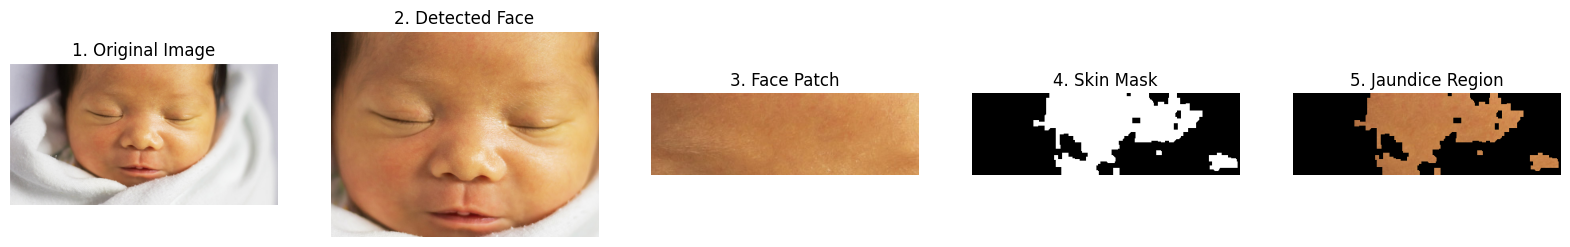

                               0
Mean                5.215262e+01
Standard Deviation  6.804559e+01
Skewness            5.471750e-01
Kurtosis           -1.682041e+00
Energy              3.641199e+01
Entropy            -1.288146e+07
Classification: Jaundiced


In [57]:


def main():
    image_path = '/content/drive/MyDrive/jaudience babies/1.jpg'
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Image not found.")
        return

    face_detector = load_face_detector()
    face = extract_face(image, face_detector)

    if face is None:
        print("Face not detected.")
        return

    h, w = face.shape[:2]
    rect_x, rect_y = int(0.25 * w), int(0.1 * h)
    rect_w, rect_h = int(0.5 * w), int(0.2 * h)
    face_patch = face[rect_y:rect_y + rect_h, rect_x:rect_x + rect_w]

    skin_region, skin_mask = detect_skin(face_patch)
    ycrcb_result, _ = ycrcb(skin_region)
    features = extract_features(ycrcb_result)

    # Create a figure and subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Adjust figsize as needed

    # Display each output in a subplot
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("1. Original Image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    axes[1].set_title("2. Detected Face")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(face_patch, cv2.COLOR_BGR2RGB))
    axes[2].set_title("3. Face Patch")
    axes[2].axis('off')

    axes[3].imshow(skin_mask, cmap='gray')
    axes[3].set_title("4. Skin Mask")
    axes[3].axis('off')

    axes[4].imshow(cv2.cvtColor(ycrcb_result, cv2.COLOR_BGR2RGB))
    axes[4].set_title("5. Jaundice Region")
    axes[4].axis('off')

    plt.show()  # Display the figure with all subplots

    # Display Extracted Features in column format using pandas
    features_df = pd.DataFrame([features])
    print(features_df.T)

    classification = classify_jaundice(features)
    print("Classification:", classification)

if __name__ == "__main__":
    main()
